# Diabetes Prediction Challenge

Yao Yan, Walter Reade, Elizabeth Park. Diabetes Prediction Challenge. https://kaggle.com/competitions/playground-series-s5e12, 2025. Kaggle.

By: Mike Johnson

****

## 1.0 Set Up

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Explainability
from sklearn.inspection import permutation_importance

In [2]:
# Load dataset
train = pd.read_csv(
    'train.csv',
    index_col = 'id')

test = pd.read_csv(
    'test.csv',
    index_col = 'id'
)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700000 entries, 0 to 699999
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  int64  
 1   alcohol_consumption_per_week        700000 non-null  int64  
 2   physical_activity_minutes_per_week  700000 non-null  int64  
 3   diet_score                          700000 non-null  float64
 4   sleep_hours_per_day                 700000 non-null  float64
 5   screen_time_hours_per_day           700000 non-null  float64
 6   bmi                                 700000 non-null  float64
 7   waist_to_hip_ratio                  700000 non-null  float64
 8   systolic_bp                         700000 non-null  int64  
 9   diastolic_bp                        700000 non-null  int64  
 10  heart_rate                          700000 non-null  int64  
 11  cholesterol_total              

****

## 2.0 Train / Dev Split

In [3]:
# Define features / target
X = train.drop(columns = ['diagnosed_diabetes']) # Features
y = train['diagnosed_diabetes'] # Target variable

# Split 80% into train and dev
X_train, X_dev, y_train, y_dev = train_test_split(X, y,
                                                  test_size=0.20, 
                                                  random_state=206)

# Define test set
X_test = test

# Confirm shape of each set
print(f"Train: {X_train.shape}")
print(f"Dev: {X_dev.shape}")
print(f"Test: {X_test.shape}")

Train: (560000, 24)
Dev: (140000, 24)
Test: (300000, 24)


****

## 3.0 Exploratory Analysis

In [4]:
# Create df for EDA
df_train = pd.concat([X_train, y_train], axis=1)

### 3.1 Distribution Analysis

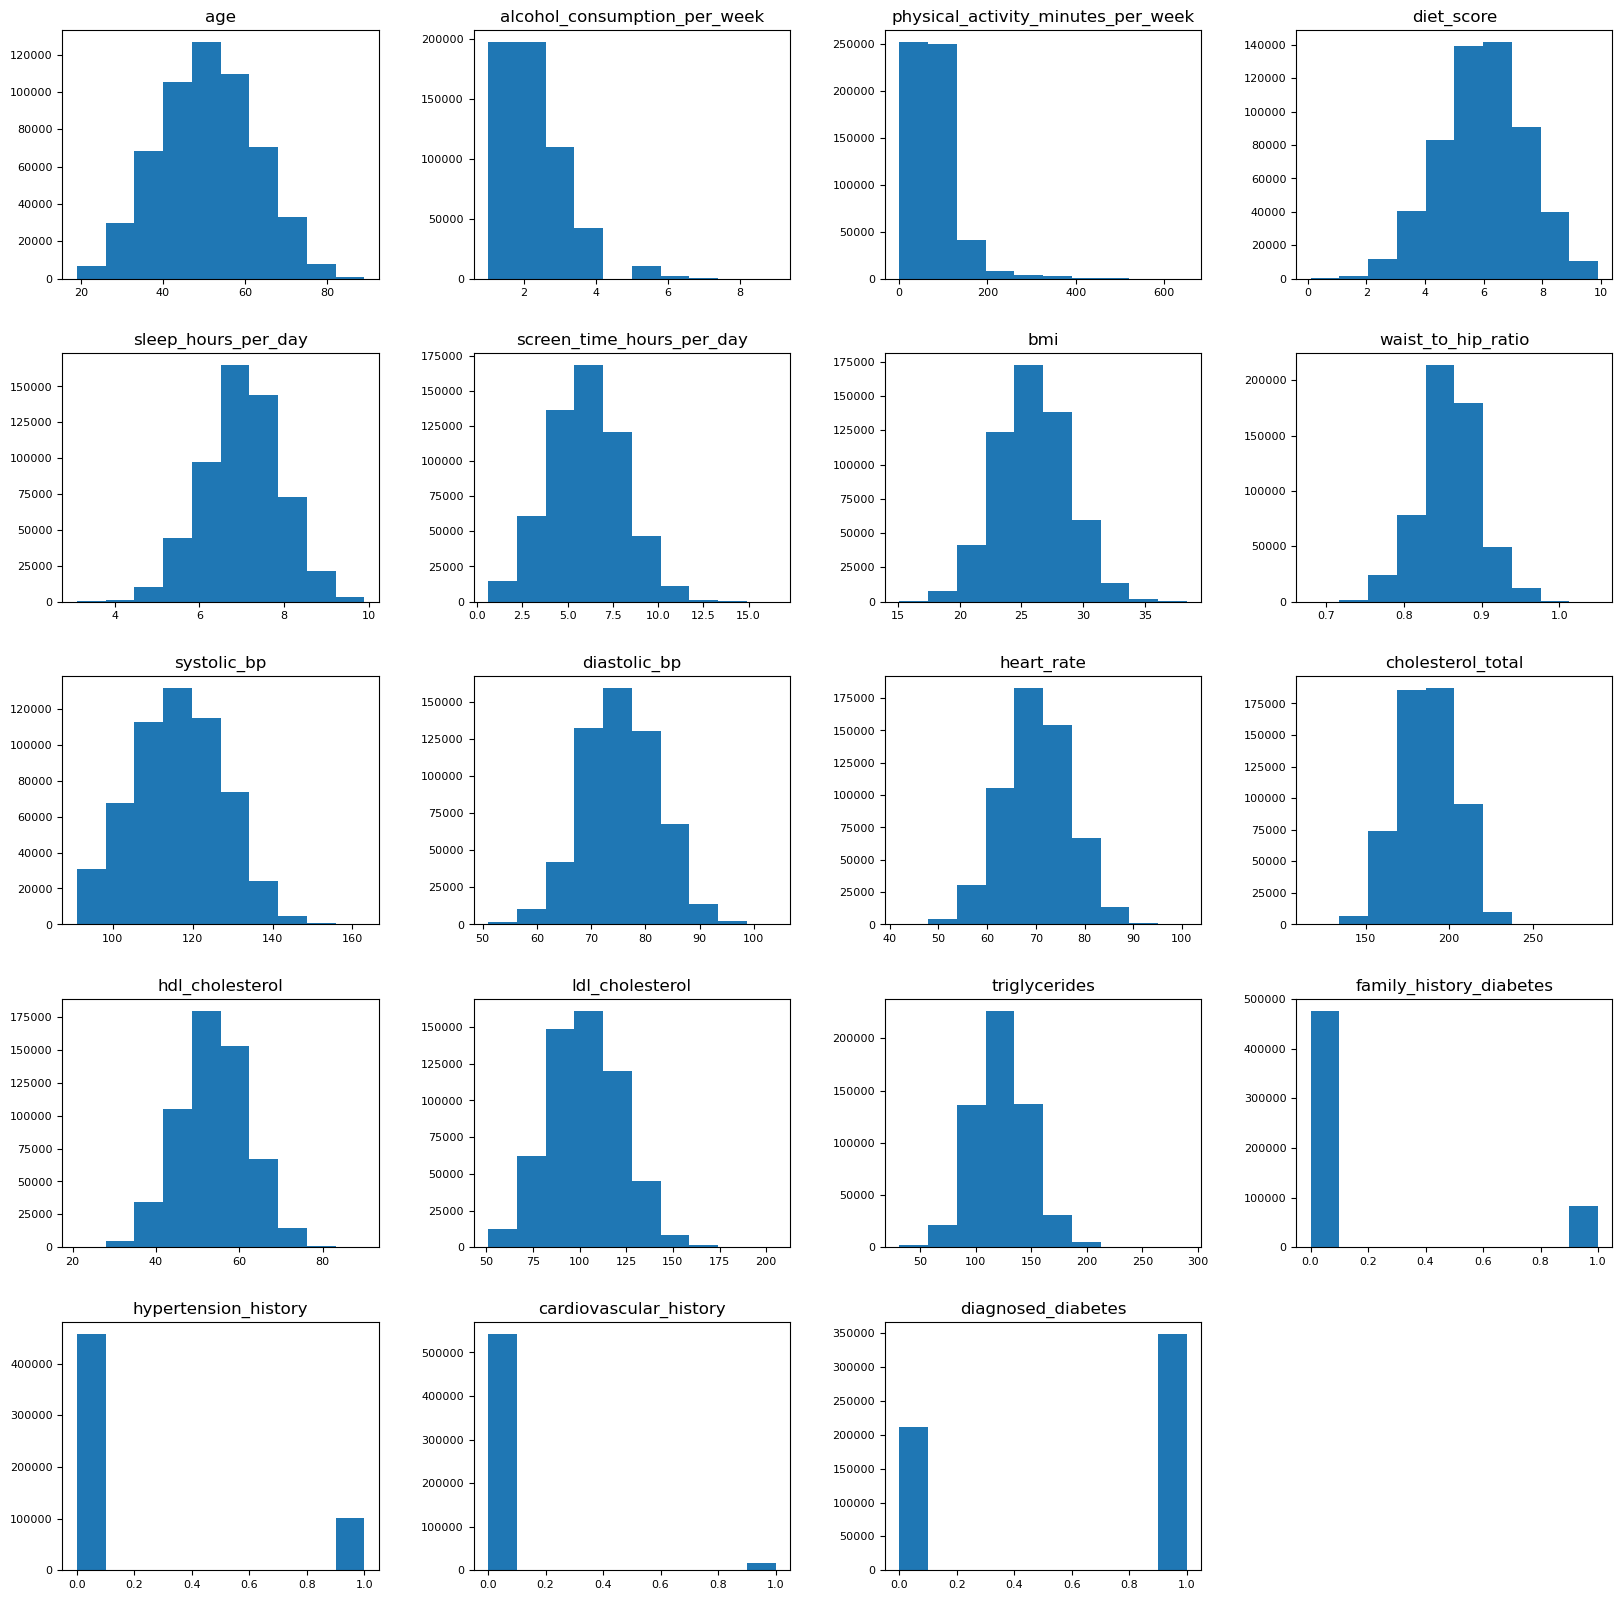

In [5]:
# Visualize features
df_train.hist(figsize=(20, 20), 
              xlabelsize=8, 
              ylabelsize=8,
              grid = False);

### 3.2 Pair Plot

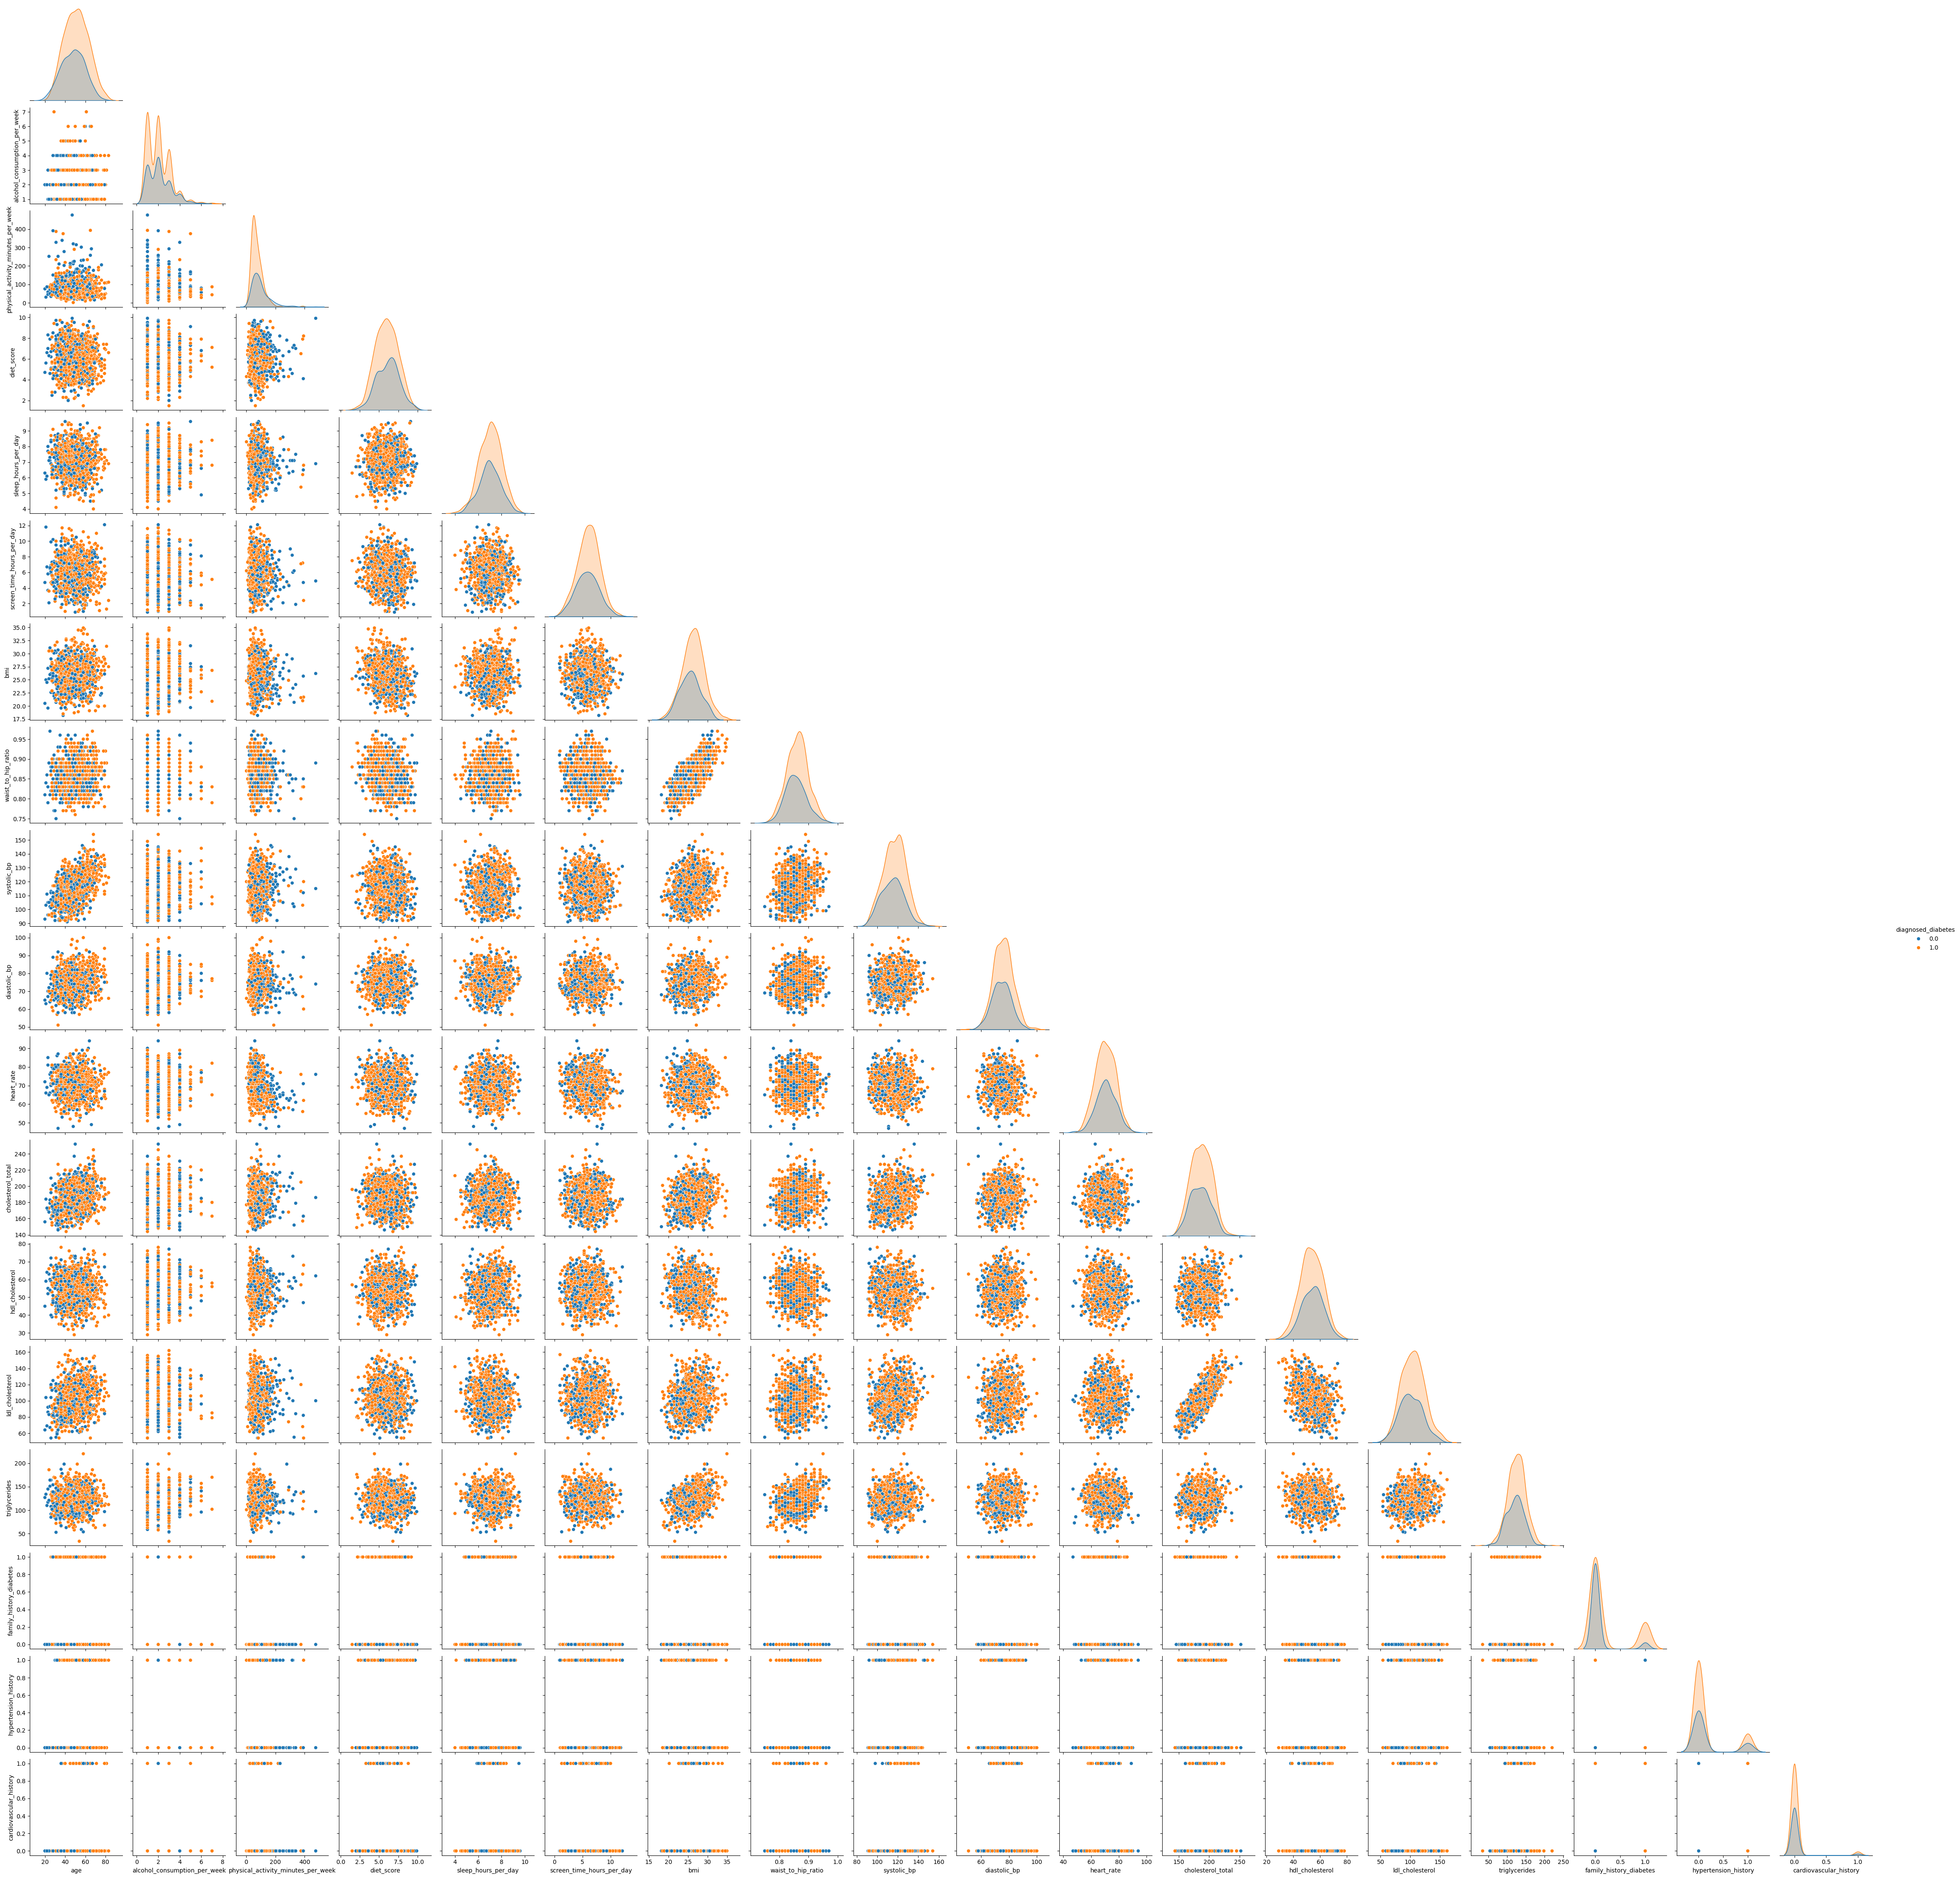

In [6]:
# Get random sample from training set
df_sample = df_train.sample(n=1000, random_state=206)

# Create paiplot
sns.pairplot(
    data = df_sample.select_dtypes(include='number'), # Numerical columns only
    hue='diagnosed_diabetes',
    corner=True
)

plt.show()

### 3.3 Categorical Variables

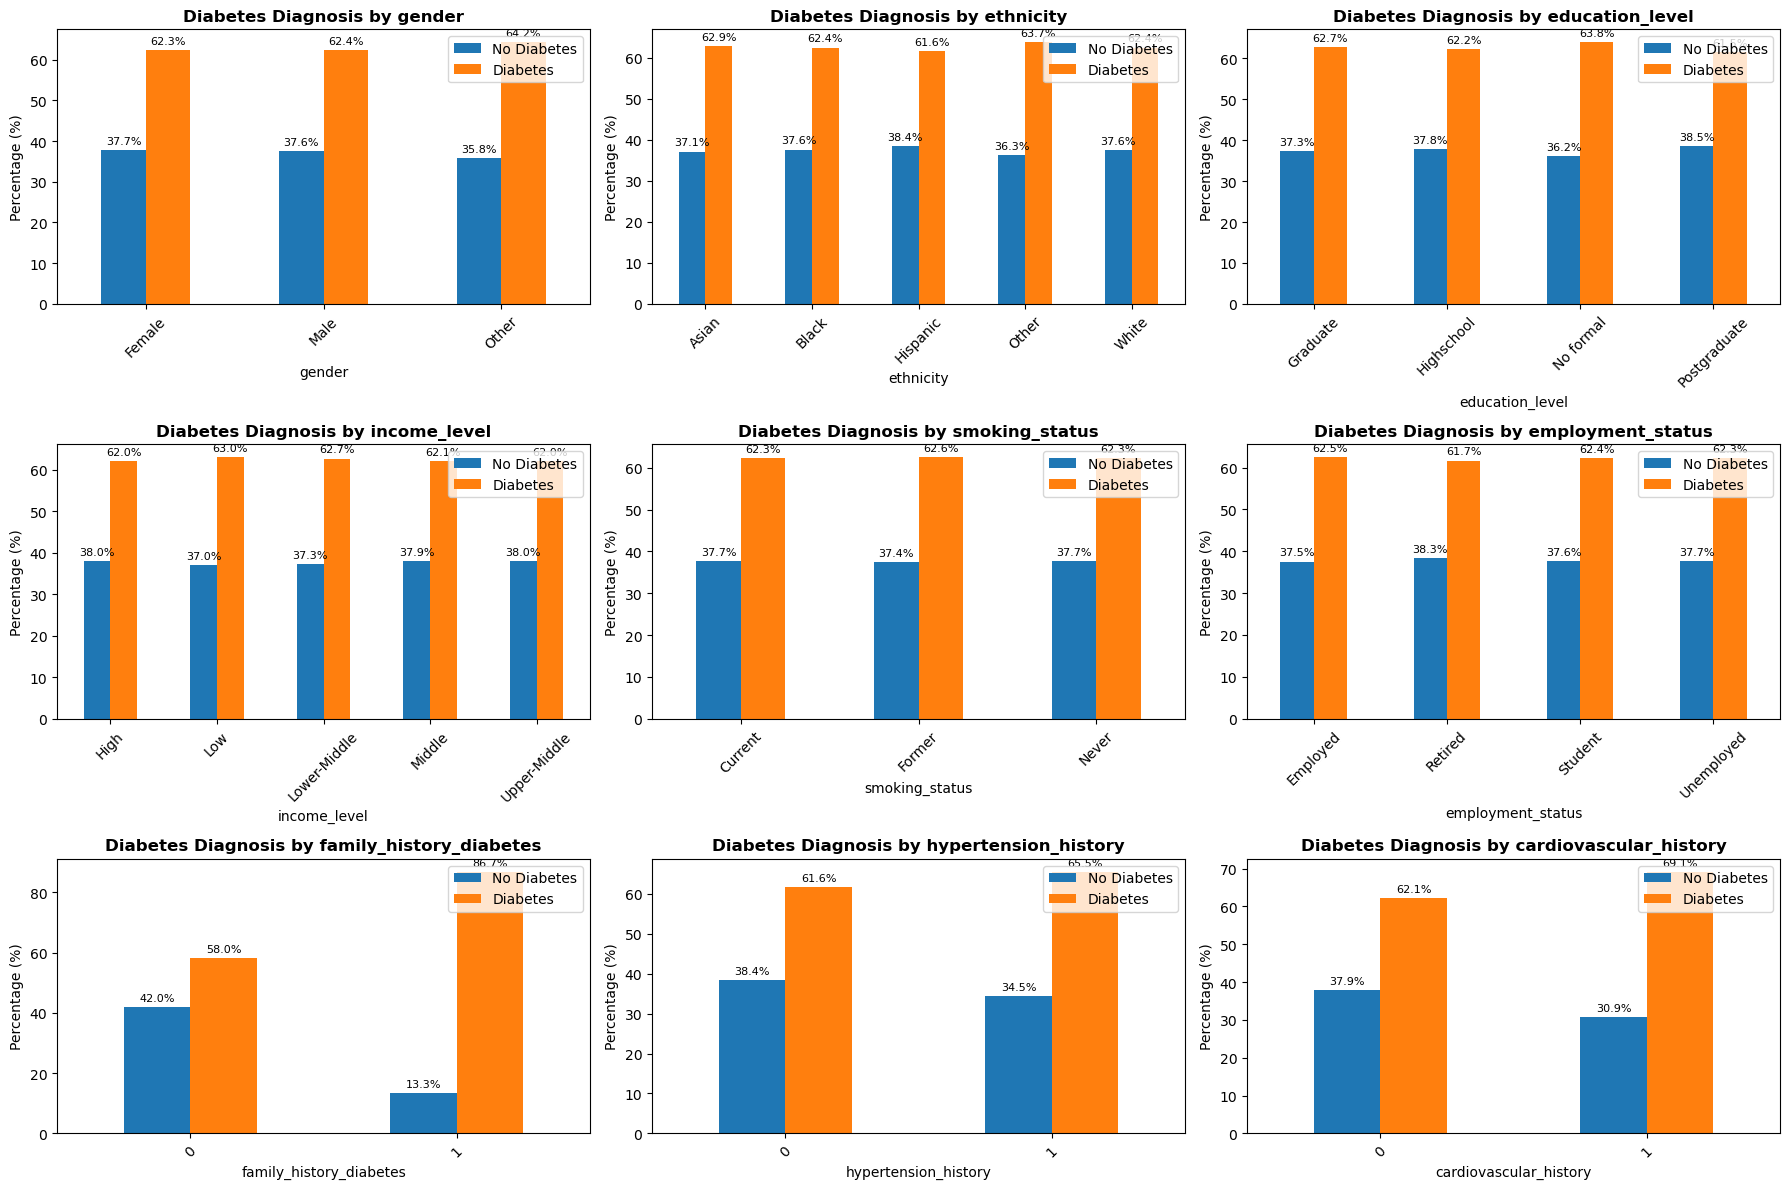

In [8]:
# Identify categorical variables (including binary numeric columns)
categorical_vars = ['gender', 'ethnicity', 'education_level', 'income_level', 
                    'smoking_status', 'employment_status', 'family_history_diabetes', 
                    'hypertension_history', 'cardiovascular_history']

# Calculate number of rows needed for subplots
n_vars = len(categorical_vars)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Create bar plot for each categorical variable
for idx, var in enumerate(categorical_vars):
    ax = axes[idx]
    
    # Create cross-tabulation
    ct = pd.crosstab(df_train[var], df_train['diagnosed_diabetes'], normalize='index') * 100
    
    # Plot
    ct.plot(kind='bar', ax=ax)
    ax.set_title(f'Diabetes Diagnosis by {var}', fontsize=12, fontweight='bold')
    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel('Percentage (%)', fontsize=10)
    ax.legend(['No Diabetes', 'Diabetes'], loc='upper right')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=8)

# Remove empty subplots
for idx in range(n_vars, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

****

## 3.0 Pre Processing

### 3.1 One Hot Encoding

In [9]:
# Define columns to be encoded
categorical_cols = X_train.select_dtypes(include = ['object']).columns

categorical_cols

Index(['gender', 'ethnicity', 'education_level', 'income_level',
       'smoking_status', 'employment_status'],
      dtype='object')

In [10]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore', drop = 'first')

# Fit encoder on training set
encoder.fit(X_train[categorical_cols])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [11]:
# Function to apply the transformation to any set
def apply_one_hot_encoding(data_df, encoder, cat_cols):
    
    # 1. Select and transform the categorical data
    encoded_data = encoder.transform(data_df[cat_cols])
    
    # 2. Convert the encoded data array into a DataFrame
    # Use the feature names learned during the fit process
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=encoder.get_feature_names_out(cat_cols),
        index=data_df.index  # Match the original index
    )
    
    # 3. Drop the original categorical columns
    non_cat_df = data_df.drop(columns=cat_cols)
    
    # 4. Concatenate the original (numerical/target) and the new encoded features
    return pd.concat([non_cat_df, encoded_df], axis=1)

In [12]:
# Apply the transformation to all three sets using the fitted encoder
X_train = apply_one_hot_encoding(X_train, encoder, categorical_cols)
X_dev = apply_one_hot_encoding(X_dev, encoder, categorical_cols)
X_test = apply_one_hot_encoding(X_test, encoder, categorical_cols)

***

## 4.0 Baseline Model

In [14]:
# Train baseline model
model_0 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', random_state=206))
])

model_0.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced',
                                    random_state=206))])

In [17]:
# Define function to get model metrics
def model_metrics(X, y, model, show_roc=True):
    """
    Comprehensive classification metrics for binary classification.
    """
    
    # Make predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]  # Probability for class 1
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    
    # Print metrics
    print("=" * 60)
    print("MODEL PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("\n" + "=" * 60)
    print("Classification Report:")
    print("=" * 60)
    print(classification_report(y, y_pred, 
                                target_names=['Not Transported', 'Transported'],
                                digits=4))
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes'],
                cbar_kws={'label': 'Count'})
    axes[0].set_xlabel("Predicted", fontsize=12)
    axes[0].set_ylabel("Actual", fontsize=12)
    axes[0].set_title(f"Confusion Matrix\n(Accuracy: {accuracy:.4f})", fontsize=14)
    
    # 2. ROC Curve
    if show_roc:
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
        axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
        axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
        axes[1].set_xlabel("False Positive Rate", fontsize=12)
        axes[1].set_ylabel("True Positive Rate", fontsize=12)
        axes[1].set_title("ROC Curve", fontsize=14)
        axes[1].legend(loc='lower right')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage:
# accuracy, predictions = model_metrics(X_dev, y_dev, model_pipeline)

MODEL PERFORMANCE METRICS
Accuracy:  0.6266
ROC-AUC:   0.6939

Classification Report:
                 precision    recall  f1-score   support

Not Transported     0.5035    0.6785    0.5781     52775
    Transported     0.7537    0.5953    0.6652     87225

       accuracy                         0.6266    140000
      macro avg     0.6286    0.6369    0.6216    140000
   weighted avg     0.6594    0.6266    0.6323    140000



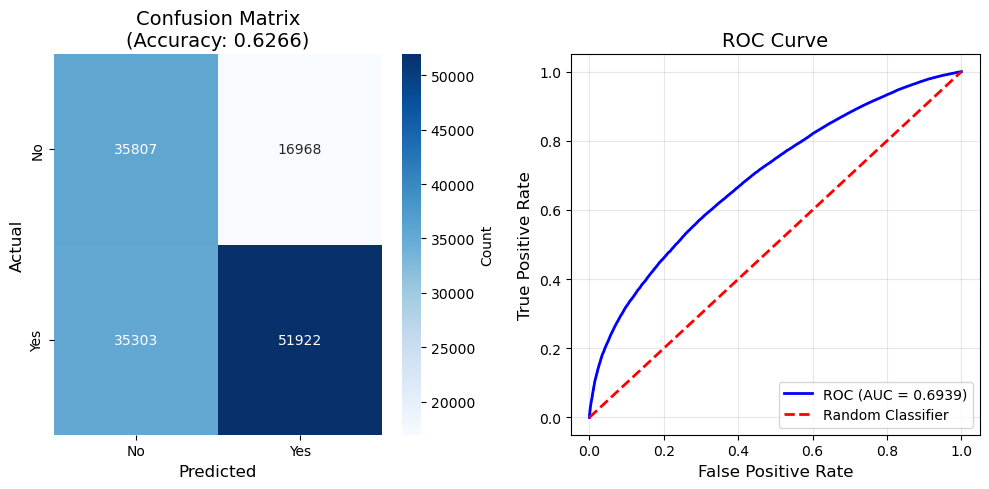

In [18]:
# Get baseline metrics
model_metrics(X_dev, y_dev, model_0)

In [21]:
# Define function for permutation importance
def feature_importance(model, 
                       X, 
                       y, 
                       n_repeats = 1,
                       random_state = 206):
    
    # Compute permutation importance
    result = permutation_importance(model, 
                                    X, 
                                    y, 
                                    n_repeats = n_repeats, 
                                    random_state = random_state)
    
    # Create dataframe for permutation importances
    feature_names = X.columns
    importance = pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})
    importance = importance.sort_values(by = 'Importance', ascending = False)

    # Plot permutation impoprtances
    sns.barplot(data = importance.head(10), y = 'Feature', x = 'Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Permutation Feature Importances - Top 10')
    plt.show()

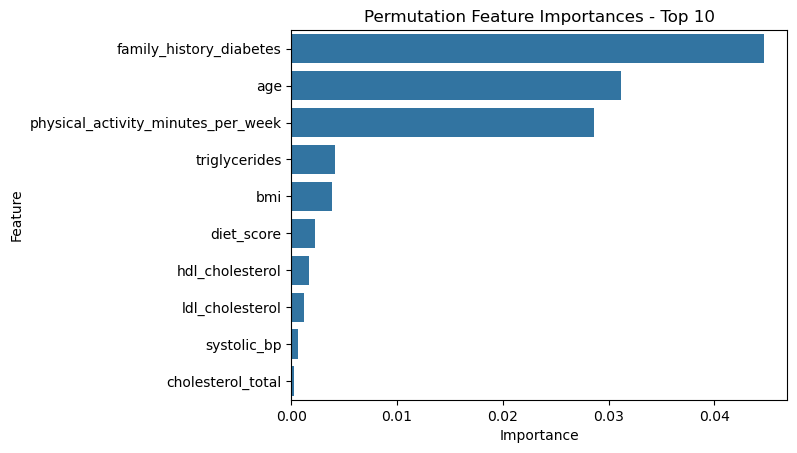

In [22]:
feature_importance(model_0,
                   X_train,
                   y_train,
                   n_repeats = 1,
                   random_state = 206)